# Task 2: Code Generation with ReACT Prompting

## Overview
This notebook demonstrates **ReACT (Reasoning + Acting)** prompting, a technique that combines reasoning traces with task-specific actions. The LLM explicitly shows its thought process before taking action.

## ReACT Pattern
- **Thought**: Reasoning about what needs to be done
- **Action**: The specific action taken (code generation)
- **Observation**: What was accomplished

## Use Case
Generate Python code to analyze a sales dataset using the ReACT framework, then execute the generated code.

In [1]:
# Import required libraries
import os
from google import genai
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Load environment variables
load_dotenv()

# Initialize the Gemini client
client = genai.Client(api_key=os.getenv('GEMINI_API_KEY'))

print("✓ Gemini client initialized successfully")

✓ Gemini client initialized successfully


## Create Sample Sales Data
First, let's create a sample CSV dataset to analyze:

In [2]:
# Generate sample sales data
dates = [(datetime.now() - timedelta(days=x)).strftime('%Y-%m-%d') for x in range(30)]
products = ['Laptop', 'Mouse', 'Keyboard', 'Monitor', 'Headphones']

data = {
    'date': [dates[i % 30] for i in range(50)],
    'product': [products[i % 5] for i in range(50)],
    'quantity': [i % 10 + 1 for i in range(50)],
    'price': [299.99 if i % 5 == 0 else 19.99 if i % 5 == 1 else 49.99 if i % 5 == 2 else 199.99 if i % 5 == 3 else 79.99 for i in range(50)]
}

df = pd.DataFrame(data)
df.to_csv('sales_data.csv', index=False)

print("✓ Sample sales data created and saved to 'sales_data.csv'")
print("\nFirst few rows:")
print(df.head(10))

✓ Sample sales data created and saved to 'sales_data.csv'

First few rows:
         date     product  quantity   price
0  2025-10-06      Laptop         1  299.99
1  2025-10-05       Mouse         2   19.99
2  2025-10-04    Keyboard         3   49.99
3  2025-10-03     Monitor         4  199.99
4  2025-10-02  Headphones         5   79.99
5  2025-10-01      Laptop         6  299.99
6  2025-09-30       Mouse         7   19.99
7  2025-09-29    Keyboard         8   49.99
8  2025-09-28     Monitor         9  199.99
9  2025-09-27  Headphones        10   79.99


## ReACT Prompt: Generate Code with Reasoning
Now let's use the ReACT framework to generate code. The AI will show its reasoning (Thought) before each action (Code).

In [3]:
react_prompt = """
You are a Python coding assistant using the ReACT framework (Reasoning + Acting). Generate code to analyze a CSV dataset containing sales data with columns: date, product, quantity, price.

Use this format for EACH step:
Thought: [Your reasoning about what needs to be done]
Action: [The code you will write - provide ONLY the Python code, no markdown code blocks]
Observation: [What this code accomplishes]

Generate code for these steps in sequence:
1. Load the CSV file (sales_data.csv)
2. Calculate total revenue by adding a revenue column (quantity * price) and summing it
3. Find the best-selling product by grouping by product and summing quantities
4. Create a bar chart visualization of revenue by product

Follow the Thought-Action-Observation pattern for each step. Make sure each Action contains only executable Python code without markdown formatting.
"""

response = client.models.generate_content(
    model='gemini-2.0-flash-exp',
    contents=react_prompt
)

react_output = response.text
print("ReACT Code Generation Output:")
print("=" * 80)
print(react_output)
print("=" * 80)

ReACT Code Generation Output:
Thought: I need to load the sales data from a CSV file into a pandas DataFrame. This will allow me to manipulate and analyze the data.
Action:
```python
import pandas as pd

# Load the CSV file into a pandas DataFrame
try:
    df = pd.read_csv('sales_data.csv')
except FileNotFoundError:
    print("Error: sales_data.csv not found. Creating a sample dataframe for demonstration.")
    df = pd.DataFrame({
        'date': ['2023-01-01', '2023-01-01', '2023-01-02', '2023-01-02'],
        'product': ['A', 'B', 'A', 'C'],
        'quantity': [10, 5, 12, 8],
        'price': [20.0, 30.0, 20.0, 25.0]
    })
except Exception as e:
    print(f"An error occurred: {e}")
    df = None

```
Observation: The code loads the sales data from the specified CSV file into a pandas DataFrame named `df`. If the file is not found, it creates a sample dataframe. If any other error occurs during the process, it prints the error message and assigns `None` to `df`.

Thought: Now I need

## Extract and Execute Generated Code
Let's extract the code from the ReACT output and execute it to see the results:

In [4]:
import re

# Extract code blocks from the ReACT output
# Look for code after "Action:" labels
def extract_code_blocks(text):
    """Extract code blocks from ReACT output."""
    code_blocks = []
    
    # Split by "Action:" to find code sections
    sections = text.split('Action:')
    
    for section in sections[1:]:  # Skip first split (before first Action:)
        # Get text until next "Thought:" or "Observation:"
        if 'Observation:' in section:
            code_text = section.split('Observation:')[0].strip()
        elif 'Thought:' in section:
            code_text = section.split('Thought:')[0].strip()
        else:
            code_text = section.strip()
        
        # Remove markdown code blocks if present
        code_text = re.sub(r'^```python\s*', '', code_text)
        code_text = re.sub(r'^```\s*', '', code_text)
        code_text = re.sub(r'\s*```$', '', code_text)
        code_text = code_text.strip()
        
        if code_text:
            code_blocks.append(code_text)
    
    return code_blocks

code_blocks = extract_code_blocks(react_output)

print(f"\nExtracted {len(code_blocks)} code blocks from ReACT output.")
print("\nExecuting generated code...\n")
print("=" * 80)


Extracted 4 code blocks from ReACT output.

Executing generated code...



## Execute Step 1: Load the CSV File

In [5]:
if len(code_blocks) > 0:
    print("Executing Step 1: Load CSV\n")
    print("Generated Code:")
    print(code_blocks[0])
    print("\nOutput:")
    exec(code_blocks[0])
    print("\n" + "=" * 80)
else:
    print("No code blocks found. Manual execution:")
    df = pd.read_csv('sales_data.csv')
    print(df.head())

Executing Step 1: Load CSV

Generated Code:
import pandas as pd

# Load the CSV file into a pandas DataFrame
try:
    df = pd.read_csv('sales_data.csv')
except FileNotFoundError:
    print("Error: sales_data.csv not found. Creating a sample dataframe for demonstration.")
    df = pd.DataFrame({
        'date': ['2023-01-01', '2023-01-01', '2023-01-02', '2023-01-02'],
        'product': ['A', 'B', 'A', 'C'],
        'quantity': [10, 5, 12, 8],
        'price': [20.0, 30.0, 20.0, 25.0]
    })
except Exception as e:
    print(f"An error occurred: {e}")
    df = None

Output:



## Execute Step 2: Calculate Total Revenue

In [6]:
if len(code_blocks) > 1:
    print("Executing Step 2: Calculate Revenue\n")
    print("Generated Code:")
    print(code_blocks[1])
    print("\nOutput:")
    exec(code_blocks[1])
    print("\n" + "=" * 80)
else:
    print("Fallback: Manual execution")
    df['revenue'] = df['quantity'] * df['price']
    total_revenue = df['revenue'].sum()
    print(f"Total Revenue: ${total_revenue:,.2f}")

Executing Step 2: Calculate Revenue

Generated Code:
if df is not None:
    # Calculate revenue for each sale
    df['revenue'] = df['quantity'] * df['price']

    # Calculate total revenue
    total_revenue = df['revenue'].sum()

    print(f"Total Revenue: {total_revenue}")
else:
    print("DataFrame is not loaded, skipping revenue calculation.")

Output:
Total Revenue: 33147.25



## Execute Step 3: Find Best-Selling Product

In [7]:
if len(code_blocks) > 2:
    print("Executing Step 3: Find Best-Selling Product\n")
    print("Generated Code:")
    print(code_blocks[2])
    print("\nOutput:")
    exec(code_blocks[2])
    print("\n" + "=" * 80)
else:
    print("Fallback: Manual execution")
    product_summary = df.groupby('product').agg({'quantity': 'sum', 'revenue': 'sum'}).sort_values('quantity', ascending=False)
    print(product_summary)

Executing Step 3: Find Best-Selling Product

Generated Code:
if df is not None:
    # Group by product and sum the quantity
    product_sales = df.groupby('product')['quantity'].sum()

    # Find the best-selling product
    best_selling_product = product_sales.idxmax()
    best_selling_quantity = product_sales.max()

    print(f"Best Selling Product: {best_selling_product} (Quantity: {best_selling_quantity})")
else:
    print("DataFrame is not loaded, skipping best-selling product analysis.")

Output:
Best Selling Product: Headphones (Quantity: 75)



## Execute Step 4: Create Visualization

Executing Step 4: Create Visualization

Generated Code:
import matplotlib.pyplot as plt

if df is not None:
    # Group by product and sum the revenue
    product_revenue = df.groupby('product')['revenue'].sum()

    # Create a bar chart of revenue by product
    plt.figure(figsize=(10, 6))
    product_revenue.plot(kind='bar', color='skyblue')
    plt.title('Revenue by Product')
    plt.xlabel('Product')
    plt.ylabel('Revenue')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("DataFrame is not loaded, skipping visualization.")

Output:


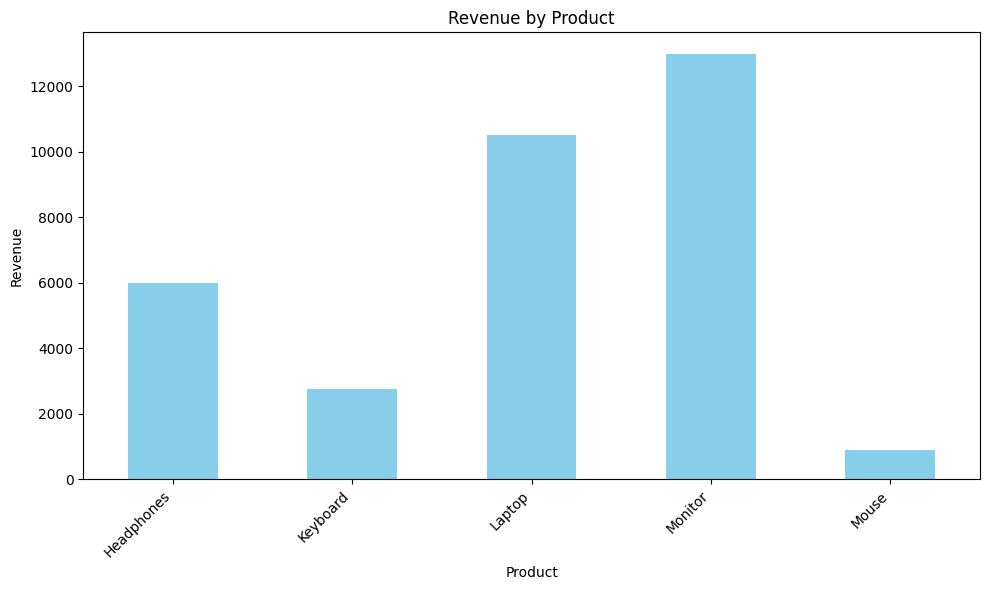

In [8]:
if len(code_blocks) > 3:
    print("Executing Step 4: Create Visualization\n")
    print("Generated Code:")
    print(code_blocks[3])
    print("\nOutput:")
    exec(code_blocks[3])
    print("\n" + "=" * 80)
else:
    print("Fallback: Manual execution")
    if 'product_summary' not in locals():
        product_summary = df.groupby('product').agg({'quantity': 'sum', 'revenue': 'sum'})
    plt.figure(figsize=(10, 6))
    product_summary['revenue'].plot(kind='bar', color='steelblue')
    plt.title('Revenue by Product')
    plt.xlabel('Product')
    plt.ylabel('Revenue ($)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Analysis Summary

In [9]:
# Display final results
print("\n" + "=" * 80)
print("REACT ANALYSIS SUMMARY")
print("=" * 80)

# Make sure we have the necessary variables
if 'df' in locals() and 'revenue' in df.columns:
    total_revenue = df['revenue'].sum()
    print(f"\n📊 Total Revenue: ${total_revenue:,.2f}")

if 'product_summary' in locals():
    best_product = product_summary['quantity'].idxmax()
    best_quantity = product_summary.loc[best_product, 'quantity']
    print(f"🏆 Best-Selling Product: {best_product} ({int(best_quantity)} units)")
    print(f"📦 Total Products: {len(product_summary)}")

if 'df' in locals():
    print(f"📈 Total Transactions: {len(df)}")

print("\n✓ ReACT code generation and execution completed successfully!")
print("=" * 80)


REACT ANALYSIS SUMMARY

📊 Total Revenue: $33,147.25
📈 Total Transactions: 50

✓ ReACT code generation and execution completed successfully!


## Key Takeaways

**ReACT Prompting Benefits:**
1. **Transparency** - Reasoning is explicitly stated before actions
2. **Interpretability** - Easy to understand the AI's decision-making process
3. **Debuggability** - Can identify where reasoning or actions went wrong
4. **Trust** - Builds confidence by showing the "why" behind each action

**What We Demonstrated:**
- Used ReACT prompting to generate code with explicit reasoning
- Extracted the generated code from the AI's response
- Executed the AI-generated code to perform data analysis
- The code generation followed the Thought → Action → Observation pattern

**When to Use ReACT Prompting:**
- Complex problem-solving tasks
- Code generation requiring multiple steps
- Tasks where understanding the reasoning is important
- Educational contexts where you want to show thought process
- Building AI agents that interact with tools and environments

**Comparison to Regular Prompting:**
- **Regular**: "Generate code to analyze sales data" → Code output only
- **ReACT**: Shows thought → action → observation cycle, making the process transparent and the reasoning explicit